<a href="https://colab.research.google.com/github/rakshithcgowda/Internship_Project/blob/main/ML_Olympiad_Customer_Opinion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np


In [2]:
import warnings

# Ignore all warnings
warnings.filterwarnings("ignore")

##Step 1. Loading the dataset

In [3]:
train_df = pd.read_csv('train.tsv', sep='\t')
test_df = pd.read_csv('test.tsv',sep='\t')

In [4]:
test_df.head()

,ID,REVIEW
0,0,"LOCATION: Letaknya di perempatan jalan, di dep..."
1,1,"Boleh lah sesekali kesini, makanan biasa saja ..."
2,2,Tempatnya enak biarpun tidak luas. Suasana nyaman
3,3,"depot bu Rudy antri, driver gojek kalau dapet ..."
4,4,saya sering banget makan di tempat ini ...tapi...


In [5]:
train_df.head()

,ID,REVIEW,LABEL
0,0,"The waiter is not friendly, the person wears n...",1
1,1,"kakaknya enak bangetttt, pelayanannya cepet ta...",5
2,2,"Pelayanan sangatt ramah, banyak promoanyaa",5
3,3,Tempatnya nyaman dan bersih,5
4,4,"Pelayanan cepat dan bagus, coba Durian Coffee ...",5


In [6]:
train_df.shape

(902, 3)

In [7]:
test_df.shape

(500, 2)

In [8]:
train_df['LABEL'].value_counts()

5    557
1    157
4    101
3     46
2     41
Name: LABEL, dtype: int64

## Step 2. Loading the Libraries

In [9]:
# basic lib for the data processing
import numpy as np
import pandas as pd
import re
import os
import pickle

# EDA

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from wordcloud import WordCloud
from collections import Counter

#nlp
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize import word_tokenize

# Ml
from sklearn.pipeline  import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix

##Step 3. Data Analysis

In [10]:
train_df.head()

,ID,REVIEW,LABEL
0,0,"The waiter is not friendly, the person wears n...",1
1,1,"kakaknya enak bangetttt, pelayanannya cepet ta...",5
2,2,"Pelayanan sangatt ramah, banyak promoanyaa",5
3,3,Tempatnya nyaman dan bersih,5
4,4,"Pelayanan cepat dan bagus, coba Durian Coffee ...",5


<Axes: >

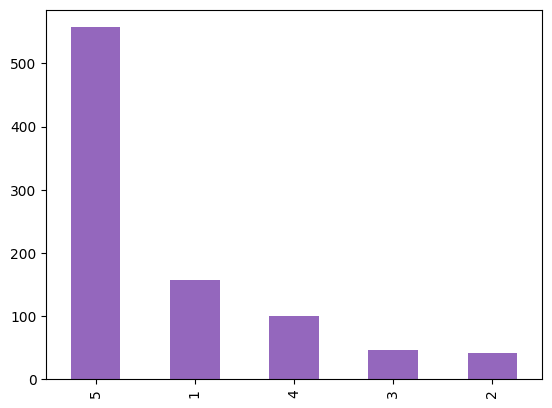

In [11]:
train_df['LABEL'].value_counts(dropna=False).plot(kind='bar', color='C4')

In [12]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 902 entries, 0 to 901
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   ID      902 non-null    int64 
 1   REVIEW  902 non-null    object
 2   LABEL   902 non-null    int64 
dtypes: int64(2), object(1)
memory usage: 21.3+ KB


In [13]:
train_df.describe()

,ID,LABEL
count,902.000000,902.000000
mean,450.500000,3.953437
std,260.529269,1.554787
min,0.000000,1.000000
25%,225.250000,3.000000
50%,450.500000,5.000000
75%,675.750000,5.000000
max,901.000000,5.000000


In [14]:
train_df.isnull().sum()

ID        0
REVIEW    0
LABEL     0
dtype: int64

In [15]:
df = train_df.rename({"LABEL":"label","REVIEW":"text"},axis = 1)
df.head()

,ID,text,label
0,0,"The waiter is not friendly, the person wears n...",1
1,1,"kakaknya enak bangetttt, pelayanannya cepet ta...",5
2,2,"Pelayanan sangatt ramah, banyak promoanyaa",5
3,3,Tempatnya nyaman dan bersih,5
4,4,"Pelayanan cepat dan bagus, coba Durian Coffee ...",5


In [16]:
df.drop(["ID"], axis=1,inplace=True)

In [17]:
df['length'] = df['text'].apply(lambda x:len(x))

In [18]:
df.head()

,text,label,length
0,"The waiter is not friendly, the person wears n...",1,64
1,"kakaknya enak bangetttt, pelayanannya cepet ta...",5,81
2,"Pelayanan sangatt ramah, banyak promoanyaa",5,42
3,Tempatnya nyaman dan bersih,5,27
4,"Pelayanan cepat dan bagus, coba Durian Coffee ...",5,66


<Axes: xlabel='length', ylabel='Density'>

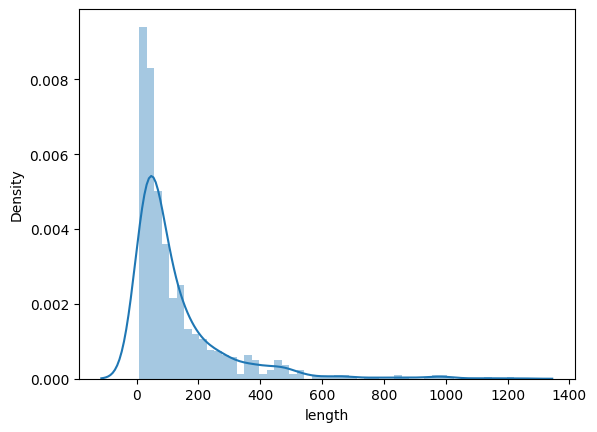

In [19]:
#analyzing text
sns.distplot(df['length'], kde=True)

<Axes: xlabel='label', ylabel='length'>

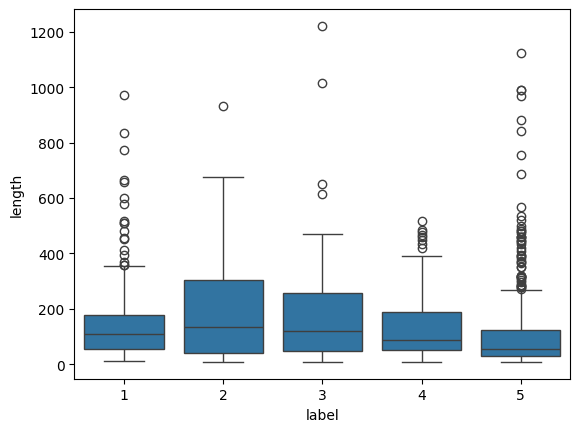

In [20]:
sns.boxplot(y='length',x='label', data=df)

In [21]:
df.tail()

,text,label,length
897,Jujurly.. pas masuk resto nya.. suasananya nya...,5,146
898,"makanan enak, pelayan baik dan ramah, bagus de...",5,93
899,Tempat ngopi area G-Walk yang buka 24/7. Cocok...,5,95
900,"Salah satu kopken favorit, pelayanan ramah, te...",5,133
901,Its fun to meet here.. its been a long time,4,43


## Step 4. Data preprocessing

In [22]:
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize
import re
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [23]:
nltk.download('stopwords')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [24]:
stop_words_indonesian = stopwords.words('indonesian')
stop_words_english = stopwords.words('english')
stop_words_combined = stop_words_indonesian + stop_words_english

In [25]:
def convert_to_lower(text):
    return text.lower()
def remove_numbers(text):
    number_pattern = r'\d+'
    without_number = re.sub(pattern=number_pattern, repl=" ", string=text)
    return without_number

import string
def remove_punctuation(text):
    return text.translate(str.maketrans('', '', string.punctuation))

def remove_stopwords(text):
    removed = []
    tokens = word_tokenize(text)
    for i in range(len(tokens)):
        if tokens[i] not in stop_words_combined:
            removed.append(tokens[i])
    return " ".join(removed)
def remove_extra_white_spaces(text):
    single_char_pattern = r'\s+[a-zA-Z]\s+'
    without_sc = re.sub(pattern=single_char_pattern, repl=" ", string=text)
    return without_sc
def lemmatizing(text):
    lemmatizer = WordNetLemmatizer()
    tokens = word_tokenize(text)
    for i in range(len(tokens)):
        lemma_word = lemmatizer.lemmatize(tokens[i])
        tokens[i] = lemma_word
    return " ".join(tokens)

In [26]:
df['text_clean'] = df['text'].apply(lambda x: convert_to_lower(x))
df['text_clean'] = df['text_clean'].apply(lambda x: remove_numbers(x))
df['text_clean'] = df['text_clean'].apply(lambda x: remove_punctuation(x))
df['text_clean'] = df['text_clean'].apply(lambda x: remove_extra_white_spaces(x))

In [27]:
df['text_clean'] = df['text_clean'].apply(lambda x: remove_stopwords(x))
df['length_after_cleaning'] = df['text_clean'].apply(lambda x: len(x))

In [28]:
df.head()

,text,label,length,text_clean,length_after_cleaning
0,"The waiter is not friendly, the person wears n...",1,64,waiter friendly person wears night guard glasses,48
1,"kakaknya enak bangetttt, pelayanannya cepet ta...",5,81,kakaknya enak bangetttt pelayanannya cepet tan...,63
2,"Pelayanan sangatt ramah, banyak promoanyaa",5,42,pelayanan sangatt ramah promoanyaa,34
3,Tempatnya nyaman dan bersih,5,27,tempatnya nyaman bersih,23
4,"Pelayanan cepat dan bagus, coba Durian Coffee ...",5,66,pelayanan cepat bagus coba durian coffee mantapp,48


## Step 5. Implementing text vectorizarion

In [29]:
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
tf_wb= TfidfVectorizer()
tf_wb.fit(df['text_clean'])
X_train = tf_wb.transform(df['text_clean'])
#Converting the sparse matrix into an array
#We then apply the toarray function to convert the sparse matrix into an array.
X_train = X_train.toarray()

In [30]:
X_train

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [31]:
y_train=df['label'].values

In [32]:
from sklearn.naive_bayes import GaussianNB
NB = GaussianNB()
NB.fit(X_train, y_train)
NB_pred= NB.predict(X_train)
print(NB_pred)
from sklearn.metrics import accuracy_score
print(accuracy_score(y_train, NB_pred))

[1 5 5 3 5 5 5 1 5 5 5 5 1 5 5 5 5 5 5 5 5 5 5 5 5 5 1 4 2 4 5 2 5 5 5 3 5
 4 4 4 2 5 5 4 5 5 5 3 1 1 4 3 5 5 5 5 1 5 4 5 5 1 5 5 5 4 5 1 5 4 4 5 5 2
 3 5 5 2 2 1 5 4 1 3 5 2 5 5 4 5 5 5 5 2 3 1 5 5 5 3 1 5 4 3 3 5 5 5 5 1 5
 1 2 5 5 2 2 5 3 5 4 1 1 5 1 5 4 4 5 4 1 1 5 5 5 1 3 4 2 5 1 5 2 5 4 3 5 5
 1 4 4 4 4 1 4 4 5 3 2 1 4 5 1 5 5 3 5 1 1 4 3 2 4 3 4 3 5 2 2 3 5 2 5 1 2
 5 1 5 5 5 4 5 5 3 5 5 5 3 5 3 5 5 1 1 5 3 2 5 1 3 2 5 5 5 2 5 5 5 5 5 2 5
 1 5 5 1 5 4 1 5 5 1 2 5 5 3 5 5 5 5 3 1 3 2 5 5 2 5 5 5 2 1 1 4 5 5 2 5 3
 1 5 2 1 3 3 5 4 5 5 2 1 5 5 4 2 5 5 4 5 5 5 5 1 1 4 5 5 2 5 5 4 5 5 5 5 1
 5 1 5 5 3 5 4 5 2 1 5 5 1 1 5 5 5 5 2 5 4 5 5 1 3 1 5 1 1 5 1 1 5 1 5 1 5
 5 5 5 5 5 5 5 5 5 4 4 5 2 4 5 2 5 5 5 1 5 2 5 5 5 5 1 5 1 1 4 5 3 4 4 1 4
 5 3 5 4 3 2 3 5 1 3 5 3 5 5 4 5 5 5 4 5 5 5 4 2 5 2 5 5 5 1 1 5 4 2 5 1 5
 4 1 5 1 3 1 4 5 1 2 4 5 2 4 5 4 3 1 5 5 1 1 4 5 5 5 2 5 1 1 5 1 5 5 5 5 4
 5 5 5 5 5 5 4 1 5 1 5 1 2 5 5 3 5 5 1 5 5 5 5 3 3 1 5 1 4 5 5 1 5 5 5 4 4
 5 4 3 5 5 5 5 4 5 1 3 4 

In [33]:
from imblearn.over_sampling import RandomOverSampler

In [34]:
from collections import Counter
Counter(y_train)

Counter({1: 157, 5: 557, 2: 41, 4: 101, 3: 46})

In [35]:
ROS = RandomOverSampler(random_state=42)

In [36]:
X_train_ros, y_train_ros = ROS.fit_resample(X_train, y_train)

In [37]:
Counter(y_train_ros)

Counter({1: 557, 5: 557, 2: 557, 4: 557, 3: 557})

In [38]:
nb = GaussianNB()
nb.fit(X_train_ros, y_train_ros)
nb_pred= NB.predict(X_train_ros)

In [39]:
from sklearn.metrics import accuracy_score
print(accuracy_score(y_train_ros, nb_pred))

0.9328545780969479


## Step 6. Oversampling

In [40]:
from imblearn.over_sampling import SMOTE, KMeansSMOTE , ADASYN,SVMSMOTE,KMeansSMOTE,BorderlineSMOTE
from imblearn.combine import SMOTEENN, SMOTETomek
from imblearn.metrics import classification_report_imbalanced

In [41]:
X=df['text_clean']
y=df['label'].values

In [42]:
def run_model(X,y,model):

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)
    print(Counter(y_train))

    vectorizer_smote = TfidfVectorizer()
    vectorizer_smote.fit(X_train)

    #Vectorizing the X_train
    X_train_vec = vectorizer_smote.transform(X_train)
    X_train_vec = X_train_vec.toarray()

    #Vectorizing the X_test
    X_test_vec = vectorizer_smote.transform(X_test)
    X_test_vec = X_test_vec.toarray()

    # transform the dataset
    oversample = model
    X_train_over, y_train_over = oversample.fit_resample(X_train_vec, y_train)
    print(Counter(y_train_over))
    nb = GaussianNB()
    nb.fit(X_train_over, y_train_over)
    y_preds = nb.predict(X_test_vec)
    score = accuracy_score(y_test,y_preds)
    print("Accuracy: ",score)
    #target_names = ['class 0', 'class 1']
    #print(classification_report_imbalanced(y_test, y_preds,     target_names=target_names))
    return score

In [43]:
#Object to over-sample the minority class(es) by picking samples at random with replacement.
oversample= RandomOverSampler(random_state=42)
ov1=run_model(X,y,model=oversample)

Counter({5: 444, 1: 126, 4: 79, 3: 39, 2: 33})
Counter({5: 444, 1: 444, 2: 444, 4: 444, 3: 444})
Accuracy:  0.4861878453038674


In [44]:
random_state=42
# over-sampling using SMOTE.
oversample=SMOTE()
ov2=run_model(X,y,model=oversample)

Counter({5: 456, 1: 128, 4: 74, 3: 37, 2: 26})
Counter({5: 456, 4: 456, 3: 456, 1: 456, 2: 456})
Accuracy:  0.4530386740331492


In [45]:
#Oversample using Adaptive Synthetic (ADASYN) algorithm.
oversample = ADASYN(random_state=42)
ov3=run_model(X,y,model=oversample)

Counter({5: 429, 1: 132, 4: 87, 3: 39, 2: 34})
Counter({3: 438, 1: 438, 5: 429, 2: 424, 4: 401})
Accuracy:  0.430939226519337


In [46]:
#Over-sampling using Borderline SMOTE
oversample=BorderlineSMOTE(random_state=42)
ov4=run_model(X,y,model=oversample)

Counter({5: 442, 1: 123, 4: 80, 3: 39, 2: 37})
Counter({2: 442, 4: 442, 5: 442, 1: 442, 3: 442})
Accuracy:  0.5193370165745856


In [47]:
#Over-sampling using SMOTE and cleaning using ENN.
oversample=SMOTEENN()
ov5=run_model(X,y,model=oversample)

Counter({5: 442, 1: 124, 4: 80, 3: 38, 2: 37})
Counter({2: 442, 3: 442, 4: 436, 1: 413, 5: 40})
Accuracy:  0.30386740331491713


In [48]:
#Over-sampling using SVM-SMOTE.
oversample=SVMSMOTE()
ov6=run_model(X,y,model=oversample)

Counter({5: 450, 1: 133, 4: 78, 3: 31, 2: 29})
Counter({5: 450, 1: 450, 4: 336, 2: 284, 3: 161})
Accuracy:  0.4530386740331492


,Model,Accuracy_score
3,Borderline-SMOTE,0.519337
0,RandomOverSampler,0.486188
1,SMOTE,0.453039
5,SVM-SMOTE,0.453039
2,ADASYN,0.430939
4,SMOTE-ENN,0.303867


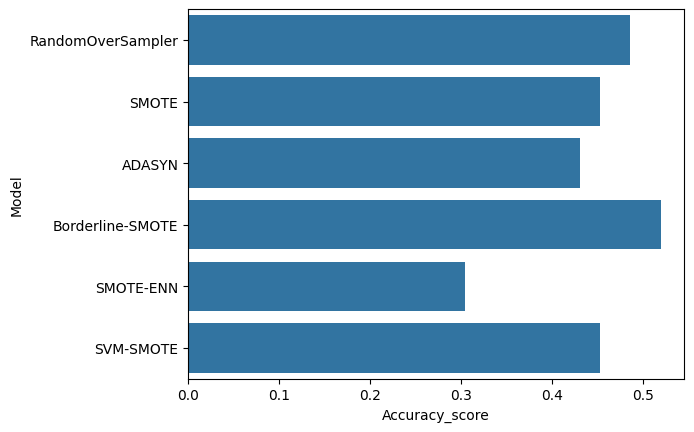

In [49]:
over_models = pd.DataFrame({
    'Model':['RandomOverSampler',
             'SMOTE',
             'ADASYN',
             'Borderline-SMOTE',
             'SMOTE-ENN',
             'SVM-SMOTE'
            ],
    'Accuracy_score' :[ov1 ,ov2, ov3, ov4,ov5,ov6
                      ]
})
sns.barplot(x='Accuracy_score', y='Model', data=over_models)
over_models.sort_values(by='Accuracy_score', ascending=False)

## Step 7. Downsampling

In [50]:
from imblearn.under_sampling  import RandomUnderSampler,AllKNN,NearMiss, TomekLinks

In [51]:
# random under-sampling
undersample=RandomUnderSampler()
un1=run_model(X,y,model=undersample)

Counter({5: 448, 1: 123, 4: 78, 2: 37, 3: 35})
Counter({1: 35, 2: 35, 3: 35, 4: 35, 5: 35})
Accuracy:  0.3259668508287293


In [52]:
# Undersample based on the AllKNN method.
undersample=AllKNN()
un2=run_model(X,y,model=undersample)

Counter({5: 431, 1: 125, 4: 92, 3: 40, 2: 33})
Counter({5: 355, 1: 49, 2: 33, 4: 14, 3: 3})
Accuracy:  0.580110497237569


In [53]:
# under-sampling based on NearMiss methods.
# NearMiss-1: Majority class examples with minimum average distance to three closest minority class examples.
undersample=NearMiss(version=1)
un3=run_model(X,y,model=undersample)

Counter({5: 448, 1: 125, 4: 76, 2: 36, 3: 36})
Counter({1: 36, 2: 36, 3: 36, 4: 36, 5: 36})
Accuracy:  0.30939226519337015


In [54]:
#Under-sampling by removing Tomek's links.
undersample=TomekLinks()
un4=run_model(X,y,model=undersample)

Counter({5: 440, 1: 121, 4: 85, 3: 40, 2: 35})
Counter({5: 416, 1: 111, 4: 70, 2: 35, 3: 27})
Accuracy:  0.47513812154696133


,Model,Accuracy_score
1,AllKNN,0.580110
3,Tomek,0.475138
0,RandomUnderSampler,0.325967
2,NearMiss,0.309392


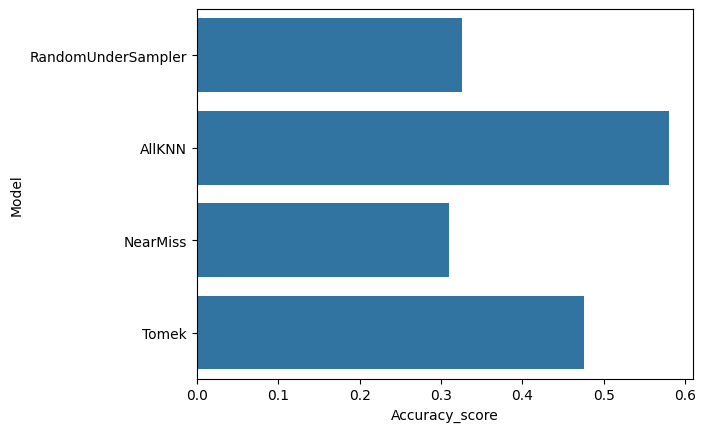

In [55]:
under_models = pd.DataFrame({
    'Model':['RandomUnderSampler',
             'AllKNN',
             'NearMiss',
             'Tomek'
            ],
    'Accuracy_score' :[un1 ,un2, un3, un4,
                      ]
})
sns.barplot(x='Accuracy_score', y='Model', data=under_models)
under_models.sort_values(by='Accuracy_score', ascending=False)

## Step 8. Oversampling Pipeline

In [56]:
#split the data into train and test sets
X=df['text_clean']
y=df['label']
#y=df['label']
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.2, random_state = 42)

In [57]:
def model(model_name,X_train,y_train,X_test,y_test):
    pipeline=Pipeline([
    ('tfidf', TfidfVectorizer()),#transform the texts into the vectorized input variables X
    ('model', model_name),
    ])
    pipeline.fit(X_train,y_train)

    preds=pipeline.predict(X_test)

    print (classification_report(y_test,preds))
    print (confusion_matrix(y_test,preds))
    print('Accuracy:', pipeline.score(X_test, y_test)*100)
    print("Training Score:",pipeline.score(X_train,y_train)*100)
    from sklearn.metrics import accuracy_score
    score = accuracy_score(y_test,preds)
    return score

In [58]:
mnb=model(MultinomialNB(),X_train,y_train,X_test,y_test)

              precision    recall  f1-score   support

           1       1.00      0.10      0.18        31
           2       0.00      0.00      0.00         6
           3       0.00      0.00      0.00         5
           4       0.00      0.00      0.00        23
           5       0.65      1.00      0.79       116

    accuracy                           0.66       181
   macro avg       0.33      0.22      0.19       181
weighted avg       0.59      0.66      0.54       181

[[  3   0   0   0  28]
 [  0   0   0   0   6]
 [  0   0   0   0   5]
 [  0   0   0   0  23]
 [  0   0   0   0 116]]
Accuracy: 65.74585635359117
Training Score: 67.82246879334258


In [59]:
rf=model(RandomForestClassifier(),X_train,y_train,X_test,y_test)

              precision    recall  f1-score   support

           1       0.83      0.48      0.61        31
           2       0.00      0.00      0.00         6
           3       0.00      0.00      0.00         5
           4       1.00      0.04      0.08        23
           5       0.71      0.99      0.83       116

    accuracy                           0.72       181
   macro avg       0.51      0.30      0.30       181
weighted avg       0.72      0.72      0.65       181

[[ 15   0   0   0  16]
 [  2   0   0   0   4]
 [  0   0   0   0   5]
 [  0   0   0   1  22]
 [  1   0   0   0 115]]
Accuracy: 72.37569060773481
Training Score: 99.72260748959778


In [60]:
svc=model(SVC(),X_train,y_train,X_test,y_test)

              precision    recall  f1-score   support

           1       0.70      0.23      0.34        31
           2       0.00      0.00      0.00         6
           3       0.00      0.00      0.00         5
           4       0.00      0.00      0.00        23
           5       0.68      1.00      0.81       116

    accuracy                           0.68       181
   macro avg       0.28      0.25      0.23       181
weighted avg       0.55      0.68      0.58       181

[[  7   0   0   0  24]
 [  3   0   0   0   3]
 [  0   0   0   0   5]
 [  0   0   0   0  23]
 [  0   0   0   0 116]]
Accuracy: 67.95580110497238
Training Score: 87.51733703190014


,Model,Accuracy_score
1,RF,0.723757
2,SVM,0.679558
0,MNB,0.657459


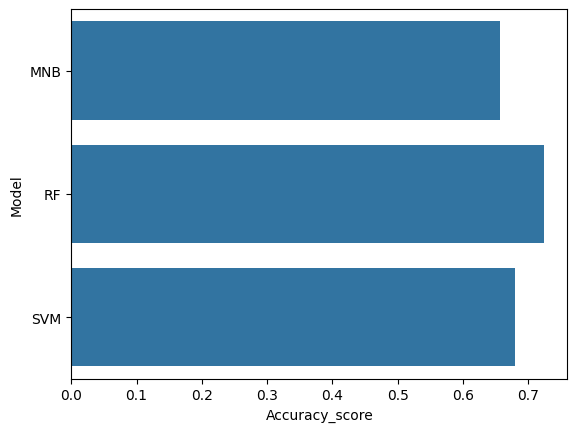

In [61]:
models = pd.DataFrame({
    'Model':['MNB','RF', 'SVM'],
    'Accuracy_score' :[mnb ,rf, svc]
})
sns.barplot(x='Accuracy_score', y='Model', data=models)
models.sort_values(by='Accuracy_score', ascending=False)

## Step 9.Final Model

In [62]:
def run_model_sampling(X,y,mlmodel,sampling=None):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)
    print(Counter(y_train))
    vectorizer_smote = TfidfVectorizer()
    vectorizer_smote.fit(X_train)
    #Vectorizing the X_train
    X_train_vec = vectorizer_smote.transform(X_train)
    X_train_vec = X_train_vec.toarray()
    #Vectorizing the X_test
    X_test_vec = vectorizer_smote.transform(X_test)
    X_test_vec = X_test_vec.toarray()
    # transform the dataset ( Sampling model)
    oversample = sampling
    if oversample:
        X_train_over, y_train_over = oversample.fit_resample(X_train_vec, y_train)
        X_train_vec= X_train_over
        y_train = y_train_over
    print(Counter(y_train))
    # Machine Learning Model
    model=mlmodel
    model.fit(X_train_vec, y_train)
    y_preds = model.predict(X_test_vec)
    score = accuracy_score(y_test,y_preds)
    print("Accuracy: ",score)
    target_names = ['class 1', 'class 2','class 3', 'class 4','class 5']
    print(classification_report_imbalanced(y_test, y_preds, target_names=target_names))
    return score

In [63]:
X=df['text_clean']
y=df['label'].values
mlmodel=RandomForestClassifier()
run_model_sampling(X,y,mlmodel)

Counter({5: 444, 1: 129, 4: 82, 3: 35, 2: 31})
Counter({5: 444, 1: 129, 4: 82, 3: 35, 2: 31})
Accuracy:  0.6685082872928176
                   pre       rec       spe        f1       geo       iba       sup

    class 1       0.54      0.54      0.92      0.54      0.70      0.47        28
    class 2       0.00      0.00      1.00      0.00      0.00      0.00        10
    class 3       0.00      0.00      1.00      0.00      0.00      0.00        11
    class 4       0.33      0.05      0.99      0.09      0.23      0.05        19
    class 5       0.70      0.93      0.34      0.80      0.56      0.33       113

avg / total       0.55      0.67      0.57      0.59      0.48      0.29       181



0.6685082872928176

In [64]:
X=df['text_clean']
y=df['label'].values
mlmodel=RandomForestClassifier()
sampling=BorderlineSMOTE(random_state=42)
run_model_sampling(X,y,mlmodel,sampling)

Counter({5: 446, 1: 130, 4: 79, 3: 34, 2: 32})
Counter({5: 446, 2: 446, 3: 446, 1: 446, 4: 446})
Accuracy:  0.6685082872928176
                   pre       rec       spe        f1       geo       iba       sup

    class 1       0.61      0.52      0.94      0.56      0.70      0.47        27
    class 2       0.00      0.00      1.00      0.00      0.00      0.00         9
    class 3       0.00      0.00      1.00      0.00      0.00      0.00        12
    class 4       0.00      0.00      0.99      0.00      0.00      0.00        22
    class 5       0.69      0.96      0.30      0.80      0.54      0.31       111

avg / total       0.51      0.67      0.56      0.58      0.43      0.26       181



0.6685082872928176

In [65]:
X=df['text_clean']
y=df['label'].values
mlmodel=RandomForestClassifier()
sampling=BorderlineSMOTE(random_state=42)
run_model_sampling(X,y,mlmodel,sampling)

Counter({5: 439, 1: 122, 4: 88, 3: 38, 2: 34})
Counter({4: 439, 5: 439, 1: 439, 2: 439, 3: 439})
Accuracy:  0.6795580110497238
                   pre       rec       spe        f1       geo       iba       sup

    class 1       0.59      0.37      0.94      0.46      0.59      0.33        35
    class 2       0.00      0.00      0.99      0.00      0.00      0.00         7
    class 3       0.00      0.00      1.00      0.00      0.00      0.00         8
    class 4       0.00      0.00      0.98      0.00      0.00      0.00        13
    class 5       0.71      0.93      0.30      0.81      0.53      0.30       118

avg / total       0.58      0.68      0.53      0.62      0.46      0.26       181



0.6795580110497238

In [66]:
X=df['text_clean']
y=df['label'].values
mlmodel=RandomForestClassifier()
sampling=AllKNN()
run_model_sampling(X,y,mlmodel,sampling)

Counter({5: 444, 1: 125, 4: 80, 3: 39, 2: 33})
Counter({5: 366, 1: 47, 2: 33, 4: 14, 3: 2})
Accuracy:  0.6629834254143646
                   pre       rec       spe        f1       geo       iba       sup

    class 1       0.89      0.25      0.99      0.39      0.50      0.23        32
    class 2       0.00      0.00      0.99      0.00      0.00      0.00         8
    class 3       0.00      0.00      1.00      0.00      0.00      0.00         7
    class 4       0.00      0.00      1.00      0.00      0.00      0.00        21
    class 5       0.65      0.99      0.13      0.79      0.36      0.14       113

avg / total       0.57      0.66      0.46      0.56      0.31      0.13       181



0.6629834254143646

##Step 10. Train Model For submission

In [67]:
def run_model_sampling2(X_train,y_train,X_test,mlmodel,sampling=None):
    X_train,y_train,X_test =X_train,y_train,X_test
    print(Counter(y_train))
    vectorizer_smote = TfidfVectorizer()
    vectorizer_smote.fit(X_train)
    #Vectorizing the X_train
    X_train_vec = vectorizer_smote.transform(X_train)
    X_train_vec = X_train_vec.toarray()
    #Vectorizing the X_test
    X_test_vec = vectorizer_smote.transform(X_test)
    X_test_vec = X_test_vec.toarray()
    # transform the dataset ( Sampling model)
    oversample = sampling
    if oversample:
        X_train_over, y_train_over = oversample.fit_resample(X_train_vec, y_train)
        X_train_vec= X_train_over
        y_train = y_train_over
    print(Counter(y_train))
    # Machine Learning Model
    model=mlmodel
    model.fit(X_train_vec, y_train)
    y_preds = model.predict(X_test_vec)
    return y_preds

In [68]:
test_df.head()

,ID,REVIEW
0,0,"LOCATION: Letaknya di perempatan jalan, di dep..."
1,1,"Boleh lah sesekali kesini, makanan biasa saja ..."
2,2,Tempatnya enak biarpun tidak luas. Suasana nyaman
3,3,"depot bu Rudy antri, driver gojek kalau dapet ..."
4,4,saya sering banget makan di tempat ini ...tapi...


In [69]:
test_df['text_clean'] = test_df['REVIEW'].apply(lambda x: convert_to_lower(x))
test_df['text_clean'] = test_df['text_clean'].apply(lambda x: remove_numbers(x))
test_df['text_clean'] = test_df['text_clean'].apply(lambda x: remove_punctuation(x))
test_df['text_clean'] = test_df['text_clean'].apply(lambda x: remove_extra_white_spaces(x))
test_df['text_clean'] = test_df['text_clean'].apply(lambda x: remove_stopwords(x))

In [70]:
X_test=test_df['text_clean']

In [71]:
X_train=df['text_clean']
y_train=df['label'].values


mlmodel=RandomForestClassifier()
sampling=BorderlineSMOTE(random_state=42)
y_pred=run_model_sampling2(X_train,y_train,X_test,mlmodel,sampling)

Counter({5: 557, 1: 157, 4: 101, 3: 46, 2: 41})
Counter({1: 557, 5: 557, 2: 557, 4: 557, 3: 557})


In [72]:
submission_df = pd.DataFrame({'ID': test_df.ID, 'LABEL': y_pred})
submission_df.to_csv('submission.csv', index=False)
print("Your submission was successfully saved!")

Your submission was successfully saved!


## Step 11 . Submission

In [74]:
sub = pd.read_csv('submission.csv')
sub.head()

,ID,LABEL
0,0,5
1,1,5
2,2,5
3,3,1
4,4,5
